In [ ]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from intrinsic_factors import intrinsic_factors_xywh
from fmow_utils import get_fmow_boxes,extrinsic_factors_fmow, validate_dict

from info_tools import compute_mutual_information, compute_mutual_information_class, str2int

class_list = ["airport",
    "border_checkpoint",
    "dam",
    "factory_or_powerplant",
    "hospital",
    "military_facility",
    "nuclear_powerplant",
    "oil_or_gas_facility",
    "place_of_worship",
    "port",
    "prison",
    "stadium"]

In [ ]:
# load precomputed table of FMOW labels and metadata
df = pd.read_pickle("../trainval_labels_factors.pkl").reset_index(drop=True)
df["class"] = df["class"].astype('category')
df["split"] = df.split.astype("category")
df = df[df.country_code=="USA"]
df = df[df["class"].isin(class_list)]
# xywh
boxes = get_fmow_boxes(df)
img_sizes = np.column_stack((df.img_width.to_numpy(), df.img_height.to_numpy()))

us_classes = list(df["class"].unique())
missing = [c for c in class_list if c not in us_classes]
missing


In [ ]:
# gather intrinsic factors (dataset agnostic)
int_fmow, int_categorical = intrinsic_factors_xywh(boxes, img_sizes)

# gather extrinsic factors (custom to FMOW)
ext_fmow, ext_categorical = extrinsic_factors_fmow(df)

# class labels
cls_fmow = {"class":df["class"].to_numpy()}
cls_categorical = {"class": True}

In [ ]:
# combine factors
factors = {**cls_fmow, **int_fmow, **ext_fmow}
is_categorical = {**cls_categorical, **int_categorical, **ext_categorical}

# map non-numeric variables to integers
factors = str2int(factors)

# make sure we have a categorical label for each factor
assert(all([k in is_categorical.keys() for k in factors.keys()]))
# make sure each factor has the same number of entries
validate_dict(factors)

/home/jbotts/repos/daml/prototype/info_tools.py:146: RuntimeWarning: invalid value encountered in divide
  nmi = mi / norm_factor


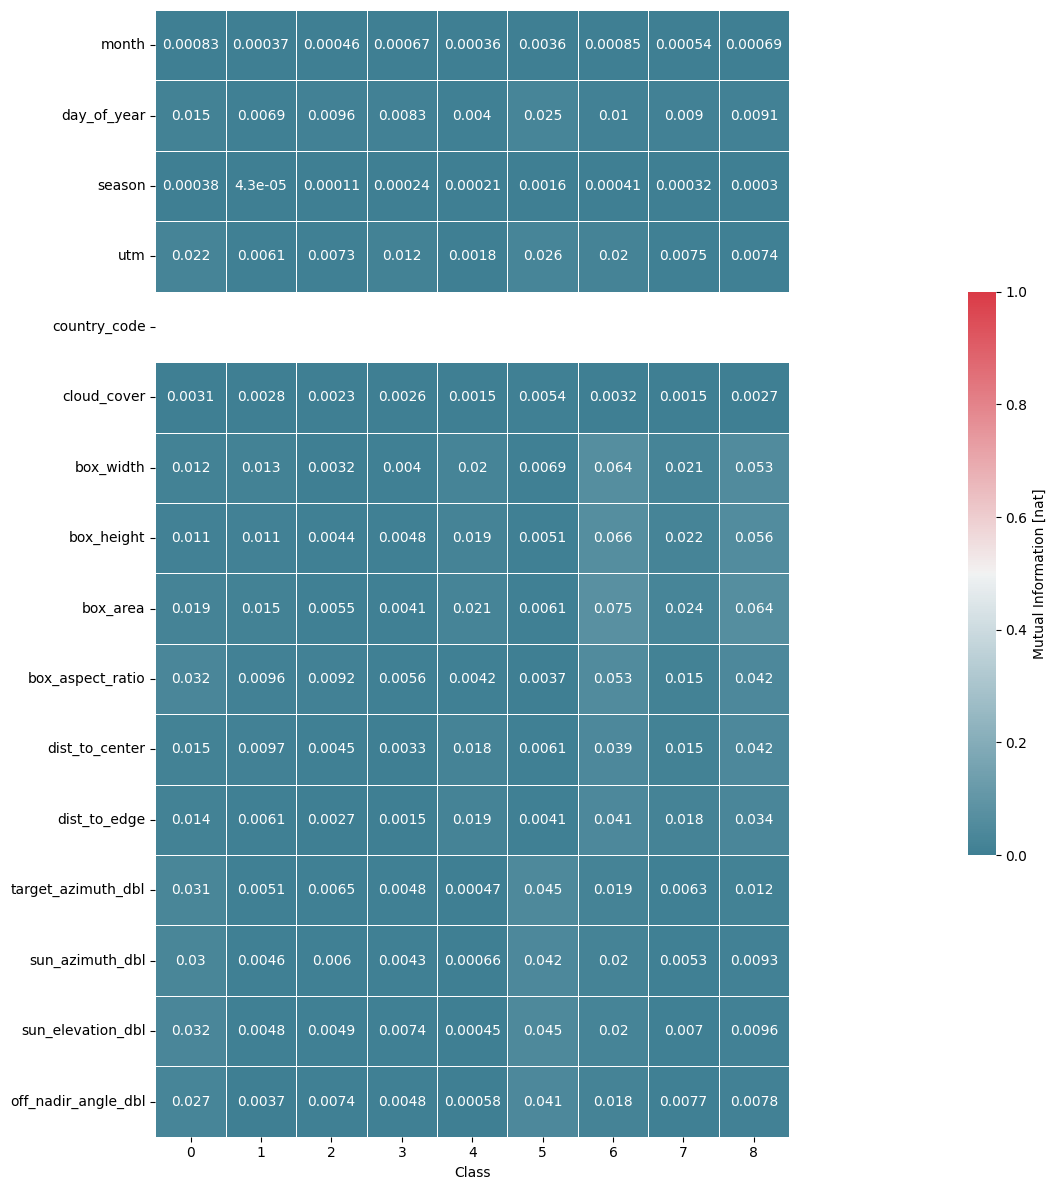

In [22]:
# MI with one-hot classes
mi,vars = compute_mutual_information_class(factors, is_categorical)
classes = np.unique(factors["class"])

f,ax = plt.subplots(figsize=(36, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot = sns.heatmap(mi.T, cmap=cmap, vmin=0, vmax=1,
        square=True, linewidths=.5, cbar_kws={"shrink": .5, "label":"Mutual Information [nat]"},
        xticklabels=classes, yticklabels=vars,
        annot=True)
plt.xlabel("Class")
plt.tight_layout()

/home/jbotts/repos/daml/prototype/info_tools.py:108: RuntimeWarning: divide by zero encountered in divide
  nmi = 0.5*(mi+mi.T) / norm_factor
/home/jbotts/repos/daml/prototype/info_tools.py:108: RuntimeWarning: invalid value encountered in divide
  nmi = 0.5*(mi+mi.T) / norm_factor


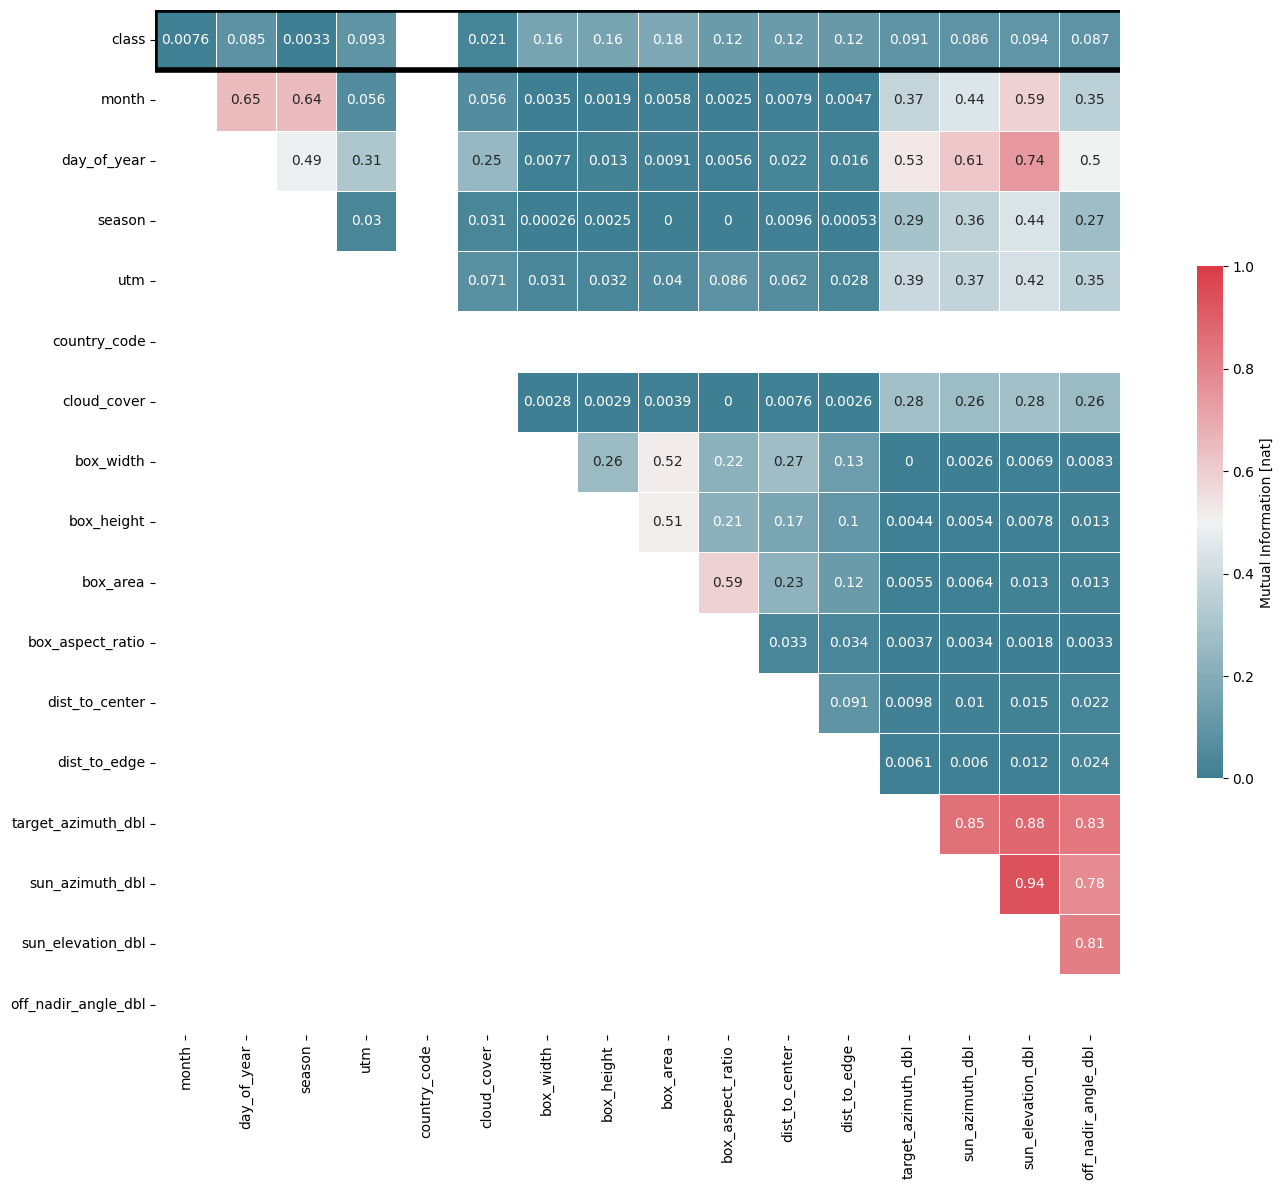

In [21]:
# MI between factors (all classes together)
mi,vars = compute_mutual_information(factors, is_categorical)
f,ax = plt.subplots(figsize=(16, 12))
mask = np.zeros_like(mi, dtype=np.bool_)
mask[np.tril_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(mi[:,1:], mask=mask[:,1:], cmap=cmap, vmin=0, vmax=1,
        square=True, linewidths=.5, cbar_kws={"shrink": .5, "label":"Mutual Information [nat]"},
        xticklabels=vars[1:], yticklabels=vars,
        annot=True)
# highlight correlation with class
ax.add_patch(Rectangle((0, 0), mi.shape[0], 1, fill=False, edgecolor='k', lw=4))
plt.tight_layout()